Intento de predecir si una persona dada ha sido victima de fraude

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# Carga de datos
df_cc = pd.read_csv('credit_card_transactions-ibm_v2.csv', usecols=["User", "Is Fraud?"])
df_users = pd.read_csv('sd254_users.csv')
df_users["User"] = range(0, len(df_users)) # Crear columna User en df_users para index
df_cc['Is Fraud?'] = df_cc["Is Fraud?"].map({"No": False, "Yes": True}) # is fraut => bool
df_frauds_per_user = df_cc.groupby("User").sum()

df_uf = df_frauds_per_user.merge(df_users, how="inner", on="User")   #merge de df_cc y df_users

In [ ]:
#Limpieza de datos
df_uf.rename(columns={"Is Fraud?": "Frauds"}, inplace=True)
# drop de cosas redundantes o innecesarias (o texto)
df_uf.drop(columns=["User", "Person", "Birth Year", "Birth Month", "Address", "Apartment", "City", "State", "Zipcode"], inplace=True)
# monedas -> int
df_uf['Per Capita Income - Zipcode'] = df_uf['Per Capita Income - Zipcode'].str.replace('$', '').astype(int)
df_uf['Yearly Income - Person'] = df_uf['Yearly Income - Person'].str.replace('$', '').astype(int)
df_uf['Total Debt'] = df_uf['Total Debt'].str.replace('$', '').astype(int)
# gender -> int
df_uf['Gender'] = df_uf["Gender"].map({"Female": 0, "Male": 1})
df_uf

,Frauds,Current Age,Retirement Age,Gender,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards
0,27,53,66,0,34.15,-117.76,29278,59696,127613,787,5
1,33,53,68,0,40.76,-73.74,37891,77254,191349,701,5
2,44,81,67,0,34.02,-117.89,22681,33483,196,698,5
3,20,63,63,0,40.71,-73.99,163145,249925,202328,722,4
4,2,43,70,1,37.76,-122.44,53797,109687,183855,675,1
...,...,...,...,...,...,...,...,...,...,...,...
1995,12,32,70,1,40.65,-73.58,23550,48010,87837,703,3
1996,50,62,65,0,38.95,-84.54,24218,49378,104480,740,4
1997,20,47,67,0,40.66,-74.19,15175,30942,71066,779,3
1998,0,66,60,1,40.24,-76.92,25336,54654,27241,618,1


In [ ]:
# el y es solo si ha sido victima o no, independiente de la cantidad
X = df_uf.drop(columns=['Frauds'])
y = df_uf['Frauds'].map(lambda x: x>0)

print(f"{y.sum()} personas con fraudes en {y.shape[0]} personas")

# Primero separamos los datos de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

1343 personas con fraudes en 2000 personas


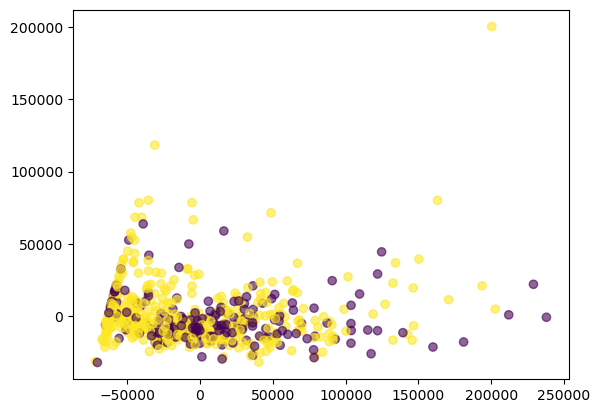

In [79]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# grafico de las clases correctas, como referencia
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_test)

fig, ax = plt.subplots()
ax.scatter(X_pca.T[0], X_pca.T[1], c=y_test, alpha=0.6)
plt.show()

# Support Vector Classifier
Supervisado, fue lo que mejores resultados dio

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC, OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Usando SVC con solo 2 clases (supervisado)

print(y_train)
clf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=42))
])
clf_pipeline.fit(X_train, y_train)
svm_pred = clf_pipeline.predict(X_test)

136      True
435     False
279     False
879     False
1982     True
        ...  
192      True
895     False
304      True
1311     True
31       True
Name: Frauds, Length: 1400, dtype: bool


Support Vector Classifier:
              precision    recall  f1-score   support

       False       0.83      0.74      0.78       197
        True       0.88      0.93      0.90       403

    accuracy                           0.86       600
   macro avg       0.86      0.83      0.84       600
weighted avg       0.86      0.86      0.86       600



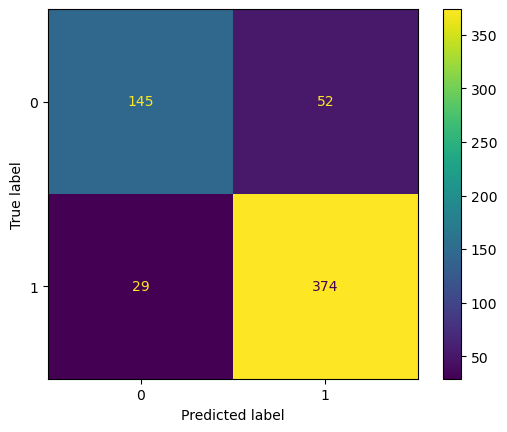

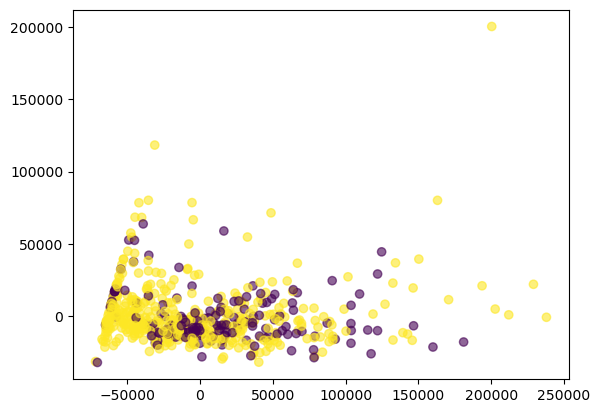

In [80]:
print("Support Vector Classifier:")
print(classification_report(y_test, svm_pred))
conf_matrix = confusion_matrix(y_test, svm_pred)
_ = ConfusionMatrixDisplay(conf_matrix).plot()

# grafico de las clases predichas
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_test)

fig, ax = plt.subplots()
ax.scatter(X_pca.T[0], X_pca.T[1], c=svm_pred, alpha=0.6)
plt.show()

# One Class SVM
Pense que podia ser decente, pero parece que no

In [ ]:
clf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', OneClassSVM())
])
clf_pipeline.fit(X_train)
ocsvm_pred = clf_pipeline.predict(X_test)
# creo que estan para el lado que es
ocsvm_pred[ocsvm_pred == 1] = 1
ocsvm_pred[ocsvm_pred == -1] = 0

136      True
435     False
279     False
879     False
1982     True
        ...  
192      True
895     False
304      True
1311     True
31       True
Name: Frauds, Length: 1400, dtype: bool


OneClassSVM:
              precision    recall  f1-score   support

       False       0.38      0.58      0.46       197
        True       0.73      0.55      0.62       403

    accuracy                           0.56       600
   macro avg       0.55      0.56      0.54       600
weighted avg       0.61      0.56      0.57       600



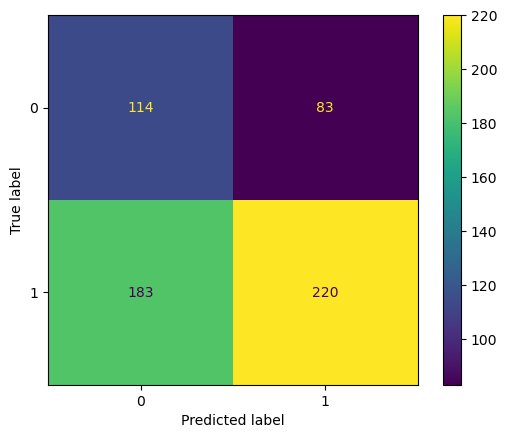

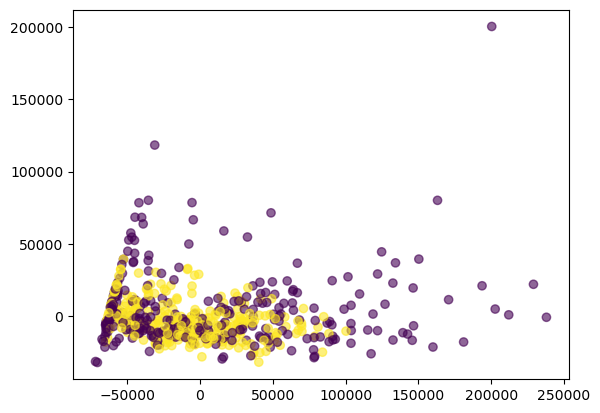

In [81]:
print("OneClassSVM:")
print(classification_report(y_test, ocsvm_pred))
conf_matrix = confusion_matrix(y_test, ocsvm_pred)
_ = ConfusionMatrixDisplay(conf_matrix).plot()
# grafico de las clases predichas
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_test)

fig, ax = plt.subplots()
ax.scatter(X_pca.T[0], X_pca.T[1], c=ocsvm_pred, alpha=0.6)
plt.show()

# DBSCAN
Como intento de clustering no supervisado, no parece dar buenos resultados

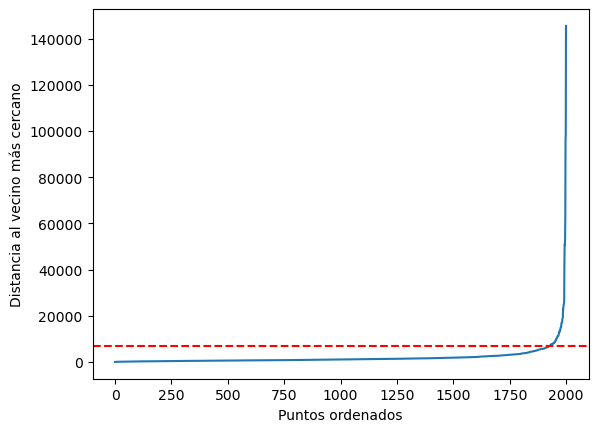

In [82]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

nbrs = NearestNeighbors(n_neighbors=3).fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

fig, ax = plt.subplots()

ax.plot(distances)
ax.axhline(y=6800, color='r', linestyle='--') #Ajuste el valor para y

plt.xlabel("Puntos ordenados")
plt.ylabel("Distancia al vecino más cercano")

plt.show()

In [ ]:
X_scaled = StandardScaler().fit_transform(X)
dbscan = DBSCAN(eps=6800, min_samples=5)

dbscan.fit(X)
db_labels = dbscan.labels_

DBSCAN:


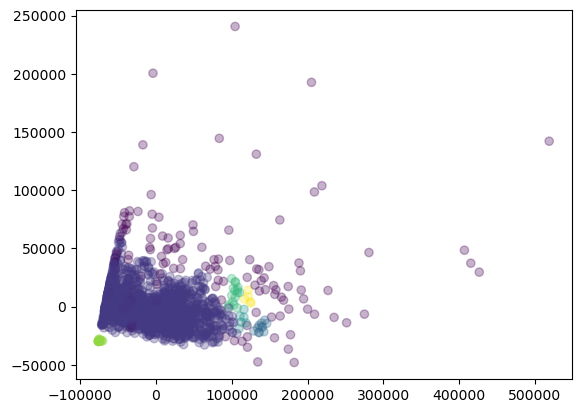

In [84]:
print("DBSCAN:")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=db_labels, alpha=0.3)
plt.show()